In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:
# nice colours! Feel free to use them :) - Daoyuan Qian 2024
colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = np.array([colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange])

In [3]:
# G: general fitting function for homotypic response
# x0 -> saturation conc.
# a -> approximatly R11
# b -> vertical displacement of final branch
# c -> transition parameter

def G(x, x0, a, b, c):
    x = np.array(x)
    _ = (x > x0).astype(int)
    y1 = x0 - c ** 2 / b + a * (x - x0)
    y2 = x - b
    return (1 - _) * x + _ * ((y1 + y2) / 2 + np.sqrt((y1 - y2) ** 2 + 4 * c ** 2) / 2)

# derivative of G, evaluated at x
def H(x, x0, a, b, c):
    x = np.array(x)
    _ = (x >= x0).astype(int)
    __ = b - x + a * x + (- c ** 2 + b * x0 - a * b * x0) / b
    return (1 - _) * 1 + _ * ((1 + a) / 2 + (a - 1) * __ / 2 / np.sqrt(4 * c ** 2 + __ **2))

# useful lines for saving fig without axis:
# plt.axis('off')
# plt.savefig('temporary.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [4]:
df = pd.read_csv('PhaseScan_data.csv').sample(frac = 1)
print(df.columns)

# feature : whether the sample is phase separated or not
# Proteil_Dil : dilute phase G3BP1 concentraiton in uM
# Protein : total G3BP1 concentration in uM
# RNA: total RNA concentraiton in ng/ul
# Suramin: total suramin concentration in uM

Index(['feature', 'Protein_Dil', 'Protein', 'RNA', 'Suramin'], dtype='object')


In [5]:
# 3D visualisation. Section data points into 3D grid with sec_num boxes along each axis

# x - suramin
# y - RNA
# z - protein 

sec_num = 20 
g_x = np.linspace(0, 10, sec_num + 1)
g_y = np.linspace(0, 150, sec_num + 1)
g_z = np.linspace(0, 6, sec_num + 1)
prob = np.ones((sec_num, sec_num, sec_num)) * (-5) # phase separation probability

# take coordinate and feature data from df
d_x = df['Suramin'].values
d_y = df['RNA'].values
d_z = df['Protein'].values
d_f = df['feature'].values.astype(int) * 2 - 1

for i in range(len(g_x) - 1):
    for j in range(len(g_y) - 1):
        for k in range(len(g_z) - 1):
            print('doing {0}/{1}/{2}'.format(i, j, k), end = '\r')
            data_mask = ((g_x[i] < d_x) & (d_x < g_x[i + 1]) &
                         (g_y[j] < d_y) & (d_y < g_y[j + 1]) &
                         (g_z[k] < d_z) & (d_z < g_z[k + 1]))
            num_points = np.sum(data_mask.astype(int))
            if num_points > 1:
                prob[i][j][k] = np.sum(d_f[data_mask]) / np.sum(data_mask.astype(int))

doing 19/19/19

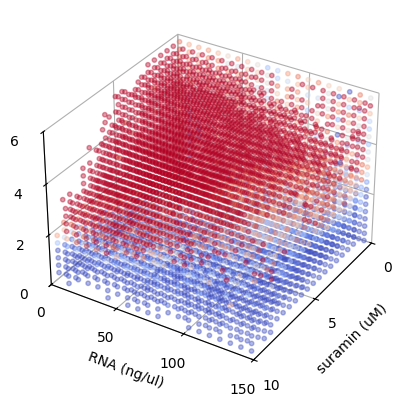

In [7]:
ax = plt.figure().add_subplot(projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

dgx = g_x[1] - g_x[0]
dgy = g_y[1] - g_y[0]
dgz = g_z[1] - g_z[0]

gx, gy, gz = np.meshgrid(g_x[:-1] + dgx / 2,
                         g_y[:-1] + dgy / 2,
                         g_z[:-1] + dgz / 2)
mask = (prob > -5) # & (0 < gx) & (gx < 5)

p = ax.scatter(gx[mask], gy[mask], gz[mask], c = prob[mask], alpha = 0.4, s = 10, cmap = 'coolwarm')

# Make legend, set axes limits and labels
ax.set_xlim(0, max(g_x))
ax.set_ylim(0, max(g_y))
ax.set_zlim(0, max(g_z))

ax.set_xticks(np.linspace(0, max(g_x), 3))
ax.set_yticks(np.linspace(0, max(g_y), 4))
ax.set_zticks(np.linspace(0, max(g_z), 4))

ax.set_xlabel('suramin (uM)')
ax.set_ylabel('RNA (ng/ul)')
ax.set_zlabel('G3BP1 (uM)')

ax.view_init(elev = 32, azim = 32)

In [22]:
# choose suramin and RNA window sizes for sectioning
dsuramin = 1
dRNA = 10

<IPython.core.display.Javascript object>


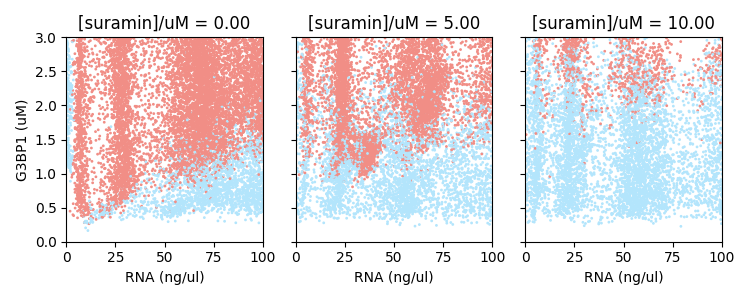

In [6]:
# 2D slices at constant suramin concentrations

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (7.5, 3))

suramin_slices = [0, 5, 10] 

for i in range(len(axes)):
    section = df[(suramin_slices[i] < df['Suramin']) & (suramin_slices[i] + dsuramin > df['Suramin'])]
    
    axes[i].scatter(section['RNA'],
                    section['Protein'],
                    color = [colors[j][0] for j in section['feature'].values.astype(int)],
                    s = 1)

    axes[i].set_title('[suramin]/uM = {0:.2f}'.format(suramin_slices[i]))
    axes[i].set_xlabel('RNA (ng/ul)')
    
axes[0].set_ylabel('G3BP1 (uM)')
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 3)
plt.tight_layout()

<IPython.core.display.Javascript object>


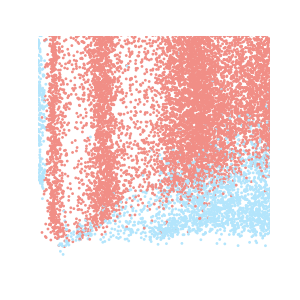

In [9]:
# save a frame-less plot
v1 = 0
plt.figure(figsize = (3, 3))
section = df[(v1 < df['Suramin']) & (v1 + 1 > df['Suramin'])]
plt.scatter(section['RNA'],
            section['Protein'],
            color = [colors[j][0] for j in section['feature'].values.astype(int)],
            s = 1)
plt.xlim(0, 100)
plt.ylim(0, 3)
plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

<IPython.core.display.Javascript object>


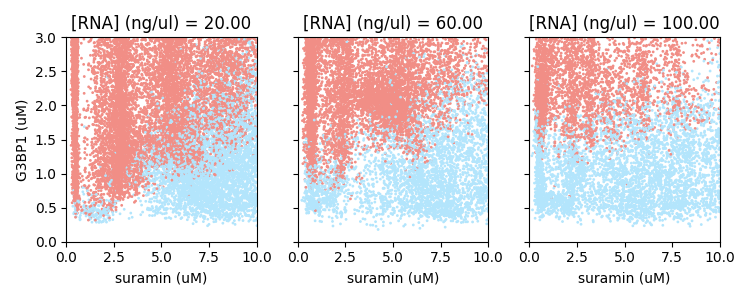

In [7]:
# 2D slices at constant RNA concentrations

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (7.5, 3))

RNA_slices = [20, 60, 100] 

for i in range(len(axes)):
    section = df[(RNA_slices[i] < df['RNA']) & (RNA_slices[i] + dRNA > df['RNA'])]
    
    axes[i].scatter(section['Suramin'],
                    section['Protein'],
                    color = [colors[j][0] for j in section['feature'].values.astype(int)],
                    s = 1)

    axes[i].set_title('[RNA] (ng/ul) = {0:.2f}'.format(RNA_slices[i]))
    axes[i].set_xlabel('suramin (uM)')
    
axes[0].set_ylabel('G3BP1 (uM)')
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 3)
plt.tight_layout()

<IPython.core.display.Javascript object>


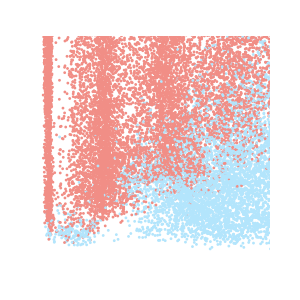

In [12]:
# save a frame-less plot, used to make figures
v1 = 20
plt.figure(figsize = (3, 3))
section = df[(v1 < df['RNA']) & (v1 + 10 > df['RNA'])]
plt.scatter(section['Suramin'],
            section['Protein'],
            color = [colors[j][0] for j in section['feature'].values.astype(int)],
            s = 1)
plt.xlim(0, 10)
plt.ylim(0, 3)
plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [11]:
2.5 // 1.5

1.0

<IPython.core.display.Javascript object>


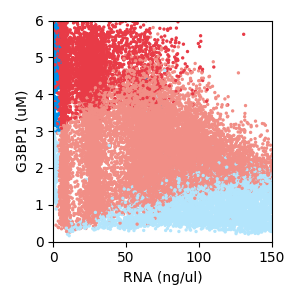

In [17]:
# plot low-suramin section with dilute bands

df['band'] = [int(x) for x in ((df['Protein_Dil']//3) % 2)]
df['fullCode'] = df['band'].values + np.array([int(x) for x in df['feature']]) * 10
section = df[(0 < df['Suramin']) & (1 > df['Suramin'])]
plt.figure(figsize = (3,3))
plt.scatter(section['RNA'],
            section['Protein'],
            c = [colors[j // 10][j % 10] for j in section['fullCode'].values.astype(int)],
            s = 2)

plt.xlabel('RNA (ng/ul)')
plt.ylabel('G3BP1 (uM)')
plt.xlim(0, 150)
plt.ylim(0, 6)
plt.tight_layout()
# plt.savefig('AAC.jpeg')

<IPython.core.display.Javascript object>


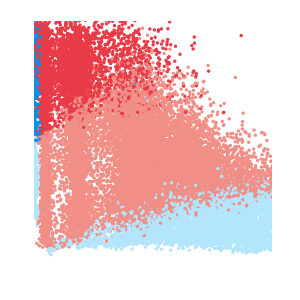

In [14]:
# save a frame-less plot, used to make figures
v1 = 3

# plot low-suramin section with dilute bands

df['band'] = [int(x) for x in ((df['Protein_Dil']//v1) % 2)]
df['fullCode'] = df['band'].values + np.array([int(x) for x in df['feature']]) * 10
section = df[(0 < df['Suramin']) & (1 > df['Suramin'])]
plt.figure(figsize = (3,3))
plt.scatter(section['RNA'],
            section['Protein'],
            c = [colors[j // 10][j % 10] for j in section['fullCode'].values.astype(int)],
            s = 2)
plt.xlim(0, 150)
plt.ylim(0, 6)
plt.tight_layout()

plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

<IPython.core.display.Javascript object>


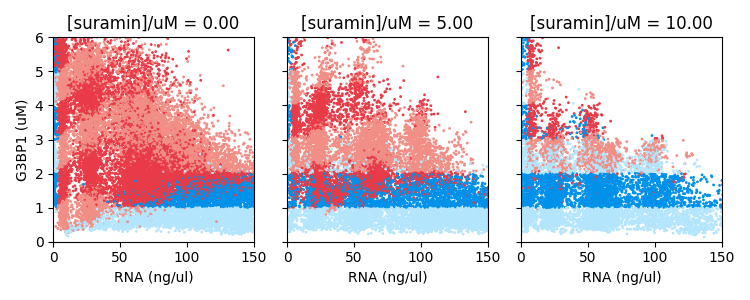

In [9]:
# 2D slices at constant suramin concentrations, with bands

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (7.5, 3))

suramin_slices = [0, 5, 10] 

for i in range(len(axes)):
    section = df[(suramin_slices[i] < df['Suramin']) & (suramin_slices[i] + dsuramin > df['Suramin'])]
    
    axes[i].scatter(section['RNA'],
                    section['Protein'],
                    color = [colors[j // 10][j % 10] for j in section['fullCode'].values.astype(int)],
                    s = 1)

    axes[i].set_title('[suramin]/uM = {0:.2f}'.format(suramin_slices[i]))
    axes[i].set_xlabel('RNA (ng/ul)')
    
axes[0].set_ylabel('G3BP1 (uM)')
axes[0].set_xlim(0, 150)
axes[0].set_ylim(0, 6)
plt.tight_layout()

<IPython.core.display.Javascript object>


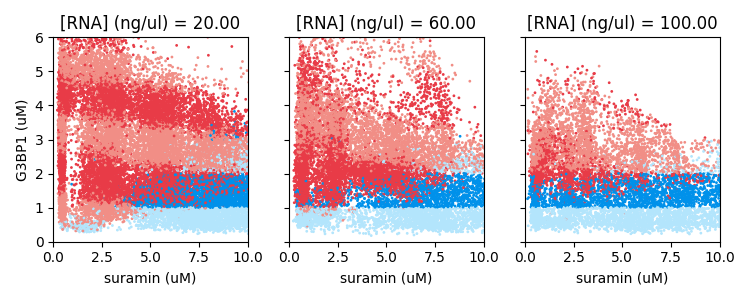

In [10]:
# 2D slices at constant RNA concentrations, with bands

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (7.5, 3))

RNA_slices = [20, 60, 100] 

for i in range(len(axes)):
    section = df[(RNA_slices[i] < df['RNA']) & (RNA_slices[i] + dRNA > df['RNA'])]
    
    axes[i].scatter(section['Suramin'],
                    section['Protein'],
                    color = [colors[j // 10][j % 10] for j in section['fullCode'].values.astype(int)],
                    s = 1)

    axes[i].set_title('[RNA] (ng/ul) = {0:.2f}'.format(RNA_slices[i]))
    axes[i].set_xlabel('suramin (uM)')
    
axes[0].set_ylabel('G3BP1 (uM)')
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 6)
plt.tight_layout()

<IPython.core.display.Javascript object>


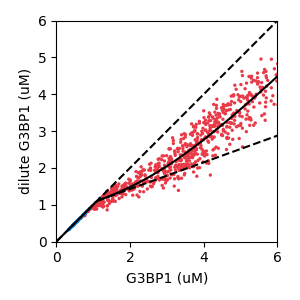

Homotypic response R11 is 0.3618836229771413


In [17]:
# illustrative homotypic response

plt.figure(figsize = (3,3))
plt.axes().set_aspect(1)

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 40) & (df['RNA'] < 50)]
x = section['Protein']
y = section['Protein_Dil']
plt.scatter(x,
            y,
            color = [colors[j][1] for j in section['feature'].values.astype(int)],
            s = 2)

popt, pcov = curve_fit(G, x, y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
R11 = H(popt[0], *popt)
print('Homotypic response R11 is {0}'.format(R11))

xx = np.linspace(0, max(x), 500)
plt.plot(xx, G(xx, *popt), c = 'black')
plt.plot(xx, xx, c = 'black', linestyle = 'dashed')
plt.plot(xx[xx > popt[0]], popt[0] + (xx[xx > popt[0]] - popt[0]) * R11, color = 'black', linestyle = 'dashed')

plt.xlabel('G3BP1 (uM)')
plt.ylabel('dilute G3BP1 (uM)')
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()
plt.savefig('response.pdf')

<IPython.core.display.Javascript object>


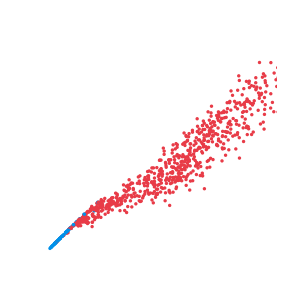

In [20]:
# illustrative homotypic response

plt.figure(figsize = (3,3))
plt.axes().set_aspect(1)

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 40) & (df['RNA'] < 50)]
x = section['Protein']
y = section['Protein_Dil']
plt.scatter(x,
            y,
            color = [colors[j][1] for j in section['feature'].values.astype(int)],
            s = 2)

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()

plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

<IPython.core.display.Javascript object>


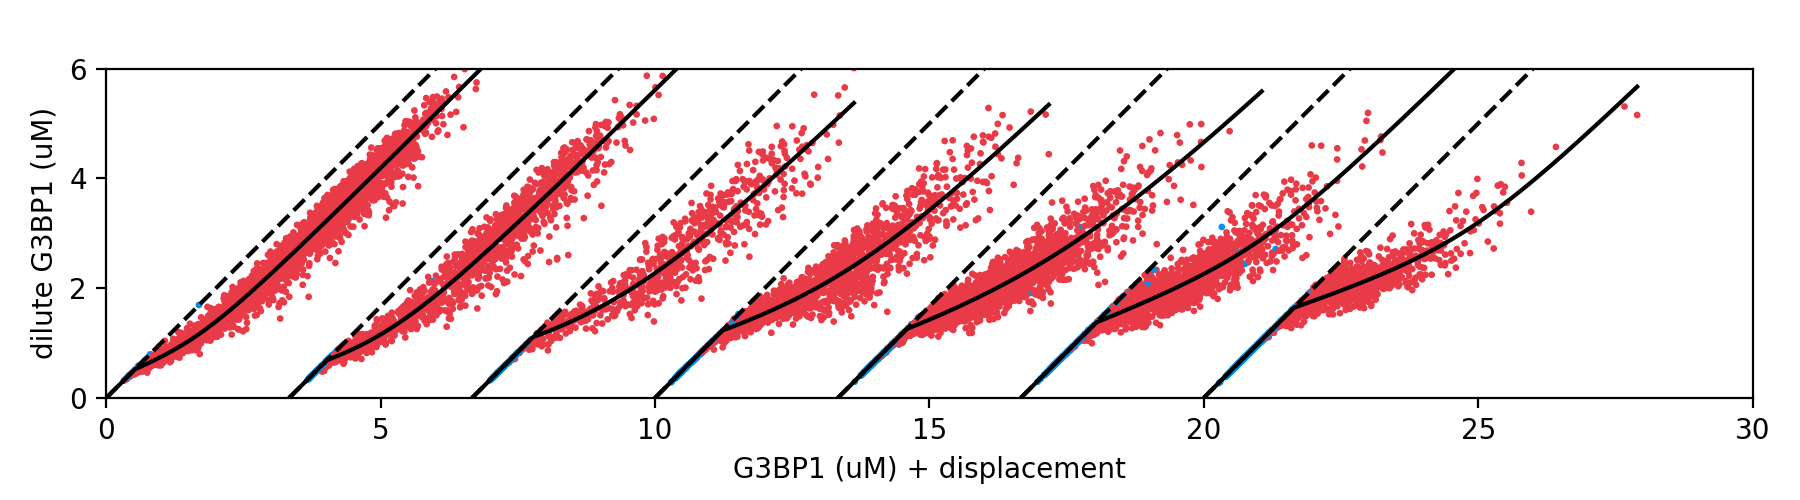

Homotypic response R11 is 0.44158007232341634
Homotypic response R11 is 0.3863942194078799
Homotypic response R11 is 0.36188298627021476
Homotypic response R11 is 0.37448452002974514
Homotypic response R11 is 0.4025949329182511
Homotypic response R11 is 0.40794785406140516
Homotypic response R11 is 0.3501925673527803


In [5]:
# illustrative homotypic responses for a range of RNA values

plt.figure(figsize = (9,2.5))
plt.axes().set_aspect(1)

for RNA in np.arange(20, 90, 10):
    x_displacement = (RNA - 20) / 3
    section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > RNA) & (df['RNA'] < RNA + 10)]
    x = section['Protein']
    y = section['Protein_Dil']
    plt.scatter(x + x_displacement,
                y,
                color = [colors[j][1] for j in section['feature'].values.astype(int)],
                s = 2)

    popt, pcov = curve_fit(G, x, y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
    R11 = H(popt[0], *popt)
    print('Homotypic response R11 is {0}'.format(R11))

    xx = np.linspace(0, max(x), 500)
    plt.plot(xx  + x_displacement, G(xx, *popt), c = 'black')
    plt.plot(xx  + x_displacement, xx, c = 'black', linestyle = 'dashed')
    
plt.xlabel('G3BP1 (uM) + displacement')
plt.ylabel('dilute G3BP1 (uM)')
plt.xlim(0, 30)
plt.ylim(0, 6)
plt.tight_layout()

<IPython.core.display.Javascript object>


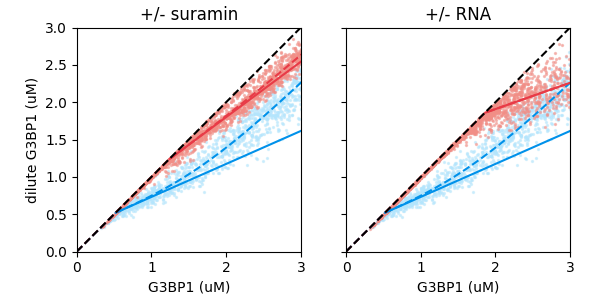

In [18]:
# illustrative homotypic response
xx = np.linspace(0, 10, 500)

fig, axes = plt.subplots(1, 2, figsize = (6, 3), sharex = True, sharey = True)

axes[0].set_aspect(1)
axes[1].set_aspect(1)

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 20) & (df['RNA'] < 30)]
x = section['Protein']
y = section['Protein_Dil']
c11 = colors[0][0]
c12 = colors[0][1]
for i in range(2):
    axes[i].scatter(x,
                    y,
                    color = c11,
                    s = 2, alpha = 0.5)
    popt_c, pcov = curve_fit(G, x, y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
    R11_c = H(popt_c[0], *popt_c)
    axes[i].plot(xx, G(xx, *popt_c), c = c12, linestyle = 'dashed')
    axes[i].plot(xx, xx, c = 'black', linestyle = 'dashed', zorder = 1000)
    axes[i].plot(xx[xx > popt_c[0]], popt_c[0] + (xx[xx > popt_c[0]] - popt_c[0]) * R11_c,
                 color = c12)

section = df[(df['Suramin'] < 6) & (df['Suramin'] > 5) & (df['RNA'] > 20) & (df['RNA'] < 30)]
x = section['Protein']
y = section['Protein_Dil']
c21 = colors[1][0]
c22 = colors[1][1]
axes[0].scatter(x,
                y,
                color = c21,
                s = 2, alpha = 0.5)
popt, pcov = curve_fit(G, x, y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
R11 = H(popt[0], *popt)
axes[0].plot(xx, G(xx, *popt), c = c22, linestyle = 'dashed')
axes[0].plot(xx[xx > popt[0]], popt[0] + (xx[xx > popt[0]] - popt[0]) * R11,
             color = c22)

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 100) & (df['RNA'] < 110)]
x = section['Protein']
y = section['Protein_Dil']
c31 = c21
c32 = c22
axes[1].scatter(x,
                y,
                color = c31,
                s = 2, alpha = 0.5)
popt, pcov = curve_fit(G, x, y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
R11 = H(popt[0], *popt)

axes[1].plot(xx, G(xx, *popt), c = c32, linestyle = 'dashed')
axes[1].plot(xx[xx > popt[0]], popt[0] + (xx[xx > popt[0]] - popt[0]) * R11,
             color = c32)

axes[0].set_title('+/- suramin')
axes[1].set_title('+/- RNA')

axes[0].set_xlabel('G3BP1 (uM)')
axes[1].set_xlabel('G3BP1 (uM)')

axes[0].set_ylabel('dilute G3BP1 (uM)')
axes[0].set_xlim(0, 3)
axes[0].set_ylim(0, 3)
plt.tight_layout()
plt.savefig('responses.pdf')

<IPython.core.display.Javascript object>


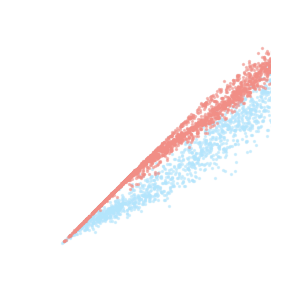

In [15]:
# illustrative homotypic response
xx = np.linspace(0, 10, 500)

plt.figure(figsize = (3, 3))

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 20) & (df['RNA'] < 30)]
x = section['Protein']
y = section['Protein_Dil']
c11 = colors[0][0]
c12 = colors[0][1]

plt.scatter(x,
            y,
            color = c11,
            s = 2, alpha = 0.5)

section = df[(df['Suramin'] < 6) & (df['Suramin'] > 5) & (df['RNA'] > 20) & (df['RNA'] < 30)]
x = section['Protein']
y = section['Protein_Dil']
c21 = colors[1][0]
c22 = colors[1][1]
plt.scatter(x,
                y,
                color = c21,
                s = 2, alpha = 0.5)

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

<IPython.core.display.Javascript object>


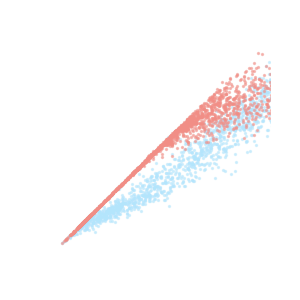

In [16]:
# illustrative homotypic response
xx = np.linspace(0, 10, 500)

plt.figure(figsize = (3, 3))

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 20) & (df['RNA'] < 30)]
x = section['Protein']
y = section['Protein_Dil']
c11 = colors[0][0]
c12 = colors[0][1]

plt.scatter(x,
                    y,
                    color = c11,
                    s = 2, alpha = 0.5)
    

section = df[(df['Suramin'] < 1) & (df['Suramin'] > 0) & (df['RNA'] > 100) & (df['RNA'] < 110)]
x = section['Protein']
y = section['Protein_Dil']
c31 = colors[1][0]
c32 = colors[1][1]
plt.scatter(x,
                y,
                color = c31,
                s = 2, alpha = 0.5)

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axis('off')
plt.savefig('snapshot.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [23]:
# change window size here to see effect on dominance values

dsuramin_analysis = dsuramin
dRNA_analysis = dRNA

In [24]:
# getting the response R11 for a range of RNA and suramin concentrations
Rss = []
suramin = np.linspace(0.5, 7.5, 20)
RNA = np.linspace(20, 100, 20)


for ii in range(len(suramin)):
    print(ii, end = '\r')
    Rs = []
    for i in range(len(RNA)):
        section = df[(df['Suramin'] < suramin[ii] + dsuramin_analysis/2) &
                     (df['Suramin'] > suramin[ii] - dsuramin_analysis/2) &
                     (df['RNA'] > RNA[i] - dRNA_analysis/2) &
                     (df['RNA'] < RNA[i] + dRNA_analysis/2)]
        _x = section['Protein']
        _y = section['Protein_Dil']
        popt, pcov = curve_fit(G, _x, _y, p0 = (2, 0.5, 1, 1), maxfev = 5000)
        #p0 = (popt)
        Rs.append(H(popt[0], *popt))
    Rss.append(Rs)
Rss = np.array(Rss)

<IPython.core.display.Javascript object>


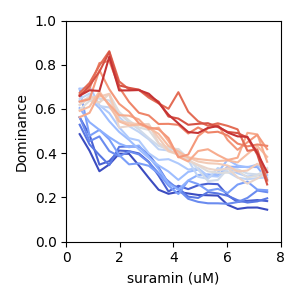

/var/folders/bt/qc1tvsd11672k1pl_c42ptwc0000gn/T/ipykernel_2616/346304826.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.plot(suramin, 1 - Rss.T[t], c = matplotlib.cm.get_cmap('coolwarm')(t / 20))


In [25]:
plt.figure(figsize = (3,3))

for t in range(len(RNA)):
    plt.plot(suramin, 1 - Rss.T[t], c = matplotlib.cm.get_cmap('coolwarm')(t / 20))

plt.xlim(0,8)
plt.ylim(0, 1)
plt.xlabel('suramin (uM)')
plt.ylabel('Dominance')
plt.tight_layout()

In [17]:
# estimate K at a single suramin concentration, look at how it changes with RNA

section = df[(df['Suramin'] < 1) &
             (df['Suramin'] > 0) &
             (df['RNA'] > 5) &
             (df['RNA'] < 20)]
Ks = []
cuts = np.linspace(2, 5, 20)
for cut in cuts:
    print(cut, end = '\r')
    RES = []
    for ii in range(10):
        _section = section.sample(frac = 0.5)
        def crosstalk(params):
            k = params[0]
            y = params[1]
            cost = 0
            gBottom = _section[_section['Protein_Dil'] < cut]
            gTop = _section[_section['Protein_Dil'] > cut]
            BottomInTop = gBottom[gBottom['Protein'] > y + k * gBottom['RNA']]
            TopInBottom = gTop[gTop['Protein'] < y + k * gTop['RNA']]
            cost += sum(abs((BottomInTop['Protein'] - (y + k * BottomInTop['RNA']))))
            cost += sum(abs((TopInBottom['Protein'] - (y + k * TopInBottom['RNA']))))
            return cost
        res = minimize(crosstalk, x0 = [0.1, cut])
        RES.append(res.x[0])
    Ks.append(RES)
Ks = np.array(Ks)

In [18]:
avgK = []
stdK = []
for K in Ks:
    avgK.append(np.mean(K))
    stdK.append(np.std(K))
avgK = np.array(avgK)
stdK = np.array(stdK)

0.0472+-0.0054


<IPython.core.display.Javascript object>


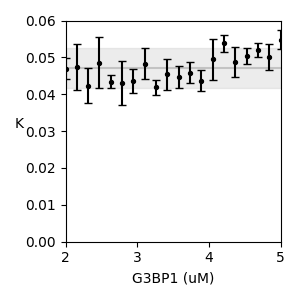

In [20]:
avgKAll = np.mean(np.reshape(Ks, -1))
stdKAll = np.std(np.reshape(Ks, -1))
print('{0:.4f}+-{1:.4f}'.format(avgKAll,stdKAll))

plt.figure(figsize = (3,3))
plt.errorbar(cuts, avgK, yerr = stdK, capsize=3, c = 'black', ls = "None", zorder = 1)
plt.scatter(cuts, avgK, c = 'black', s = 8, zorder = 1)

plt.axhline(avgKAll, color = colors[4][0], zorder = -1)
plt.fill_between([2, 5], np.ones(2) * avgKAll + stdKAll, np.ones(2) * avgKAll - stdKAll,
                 color = colors[4][0], alpha = 0.3, zorder = -1)

plt.ylim(0, 0.06)
plt.xlim(2,5)
plt.xlabel('G3BP1 (uM)')
plt.ylabel('K', rotation = 0)
plt.tight_layout()

In [20]:
# estimate K from a limited range of RNA and protein 
# this is slow :P

Kss = []
cuts = np.linspace(2, 5, 20)
suramin = np.linspace(0.5, 7.5, 20)
dsuramin = 0.5

for ii in range(len(suramin)):
    print(ii, end = '\r')
    _Kss = []
    section = df[(df['Suramin'] < suramin[ii] + dsuramin) &
                 (df['Suramin'] > suramin[ii] - dsuramin) &
                 (df['RNA'] > 5) &
                 (df['RNA'] < 20)]
    
    for cut in cuts:
        def crosstalk(params):
            k = params[0]
            y = params[1]
            cost = 0
            gBottom = section[section['Protein_Dil'] < cut]
            gTop = section[section['Protein_Dil'] > cut]
            BottomInTop = gBottom[gBottom['Protein'] > y + k * gBottom['RNA']]
            TopInBottom = gTop[gTop['Protein'] < y + k * gTop['RNA']]   
            cost += sum(abs((BottomInTop['Protein'] - (y + k * BottomInTop['RNA']))))
            cost += sum(abs((TopInBottom['Protein'] - (y + k * TopInBottom['RNA']))))
            return cost
        res = minimize(crosstalk, x0 = [0.1, cut])
        _Kss.append(res.x[0])
    Kss.append(_Kss)
Kss = np.array(Kss)

In [21]:
avgK = []
stdK = []
for K in Kss:
    avgK.append(np.mean(K))
    stdK.append(np.std(K))
avgK = np.array(avgK)
stdK = np.array(stdK)

<IPython.core.display.Javascript object>


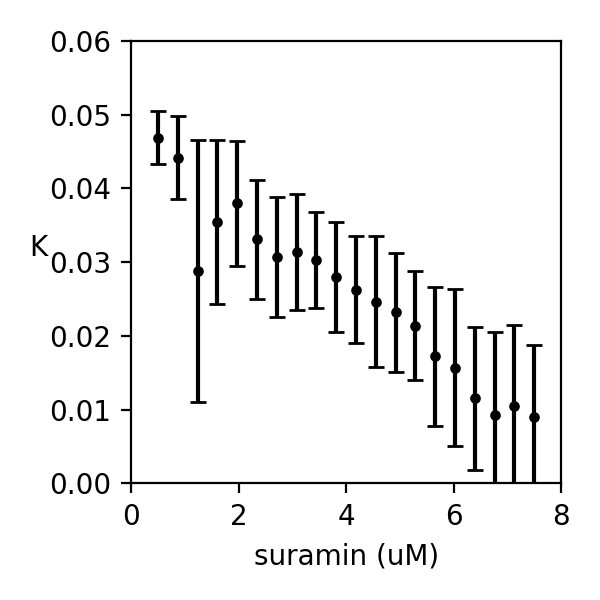

In [23]:
plt.figure(figsize = (3,3))
plt.errorbar(suramin, avgK, yerr = stdK, capsize=3, c = 'black', ls = "None")
plt.scatter(suramin, avgK, c = 'black', s = 8)

plt.ylim(0, 0.06)
plt.xlim(0, 8)
plt.xlabel('suramin (uM)')
plt.ylabel('K', rotation = 0)
plt.tight_layout()